In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd
import re
import nltk
#import demoji
import string
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, 
                             classification_report, roc_curve, auc)
from sklearn.metrics import confusion_matrix
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/suicidal-tweet-detection-dataset/Suicide_Ideation_Dataset(Twitter-based).csv


In [2]:
#demoji.download_codes()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv("/kaggle/input/suicidal-tweet-detection-dataset/Suicide_Ideation_Dataset(Twitter-based).csv")

In [4]:
df = df.dropna()

okmd

In [5]:
df['Tweet'] = df['Tweet'].astype(str)
df['Suicide'] = df['Suicide'].astype(str)
df['Tweet'] = df['Tweet'].str.lower()
df['Suicide'] = df['Suicide'].str.lower()

In [6]:
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if not word.startswith('@')]))

In [7]:
filtre = ~df['Tweet'].str.contains('&quot;')

df = df[filtre]
df.head()

,Tweet,Suicide
0,making some lunch,not suicide post
1,you want his money.,not suicide post
2,that crap took me forever to put together. iâ...,potential suicide post
3,#kiwitweets hey jer! since when did you start ...,not suicide post
5,"oh, that's good to hear. but is it over alread...",not suicide post


In [8]:
def Temizle(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'(.)\1+', r'\1', text)
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    #text = re.sub(r'\brt\b', '', text) 
    #text = re.sub(r'\btwitter\b', '', text)
    #text = re.sub(r'\btweet\b', '', text)
    return text

df['Tweet'] = df['Tweet'].apply(Temizle)
df.head()

,Tweet,Suicide
0,making some lunch,not suicide post
1,you want his money,not suicide post
2,that crap tok me forever to put together i m g...,potential suicide post
3,kiwitwets hey jer since when did you start tw...,not suicide post
5,oh that s god to hear but is it over already o...,not suicide post


/tmp/ipykernel_17/852414897.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, suicide_counts[i] + 0.5, f'{suicide_counts[i]}', ha='center', va='bottom')


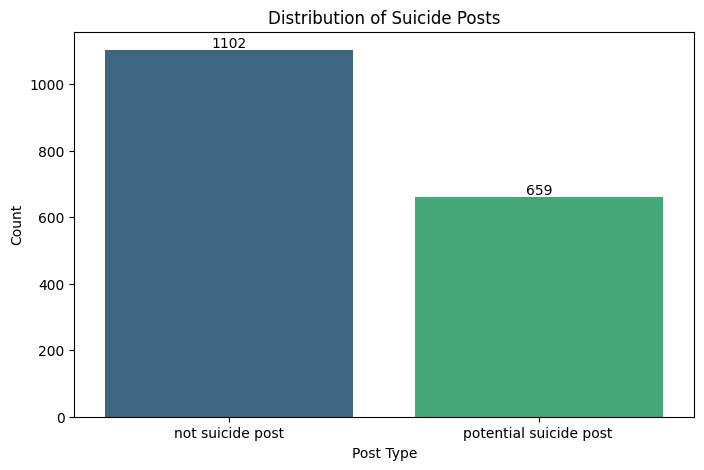

In [9]:
suicide_counts = df['Suicide'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=suicide_counts.index, y=suicide_counts.values, palette='viridis')

plt.title('Distribution of Suicide Posts')
plt.xlabel('Post Type')
plt.ylabel('Count')
for i in range(len(suicide_counts)):
    plt.text(i, suicide_counts[i] + 0.5, f'{suicide_counts[i]}', ha='center', va='bottom')
plt.show()

In [10]:
df['Output'] = df['Suicide'].apply(lambda x: 1 if x.startswith('p') else 0)

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000) 

X = tfidf_vectorizer.fit_transform(df['Tweet'])

In [12]:
def nlprocess(text):
    text = word_tokenize(text.lower())
    text = [PorterStemmer().stem(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

encoder = LabelEncoder()
vectorizer = CountVectorizer()
df['Tweet'] = df['Tweet'].apply(nlprocess)

In [13]:
X = vectorizer.fit_transform(df['Tweet']).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, df['Output'], test_size=0.2, random_state=52)

In [14]:
rf_n_model = RandomForestClassifier(n_estimators=100, random_state=52)
rf_n_model.fit(X_train, y_train)

y_pred = rf_n_model.predict(X_test)

rf_n_accuracy = accuracy_score(y_test, y_pred)
rf_n_recall = recall_score(y_test, y_pred)
rf_n_f1 = f1_score(y_test, y_pred)
print("rf_n Accuracy:", rf_n_accuracy)
print("rf_n Recall:", rf_n_recall)
print("rf_n F1-Score:", rf_n_f1)

rf_n Accuracy: 0.9660056657223796
rf_n Recall: 0.936
rf_n F1-Score: 0.9512195121951219


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


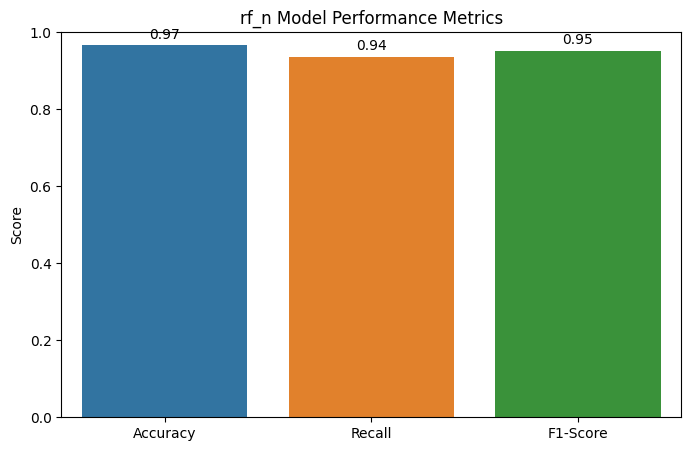

In [15]:
metrics = ['Accuracy', 'Recall', 'F1-Score']
values = [rf_n_accuracy, rf_n_recall, rf_n_f1]

plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values)

plt.title('rf_n Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)

for i in range(len(values)):
    plt.text(i, values[i] + 0.01, f'{values[i]:.2f}', ha='center', va='bottom')
plt.show()

In [16]:
y_pred_train = rf_n_model.predict(X_train)
y_pred_test = rf_n_model.predict(X_test)

In [17]:
print(f'Classification Report (Train) : \n{classification_report(y_train, y_pred_train)}')
print('-----------------------------------------------------')
print(f'\nClassification Report (Test)  : \n{classification_report(y_test, y_pred_test)}')

Classification Report (Train) : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       874
           1       1.00      1.00      1.00       534

    accuracy                           1.00      1408
   macro avg       1.00      1.00      1.00      1408
weighted avg       1.00      1.00      1.00      1408

-----------------------------------------------------

Classification Report (Test)  : 
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       228
           1       0.97      0.94      0.95       125

    accuracy                           0.97       353
   macro avg       0.97      0.96      0.96       353
weighted avg       0.97      0.97      0.97       353



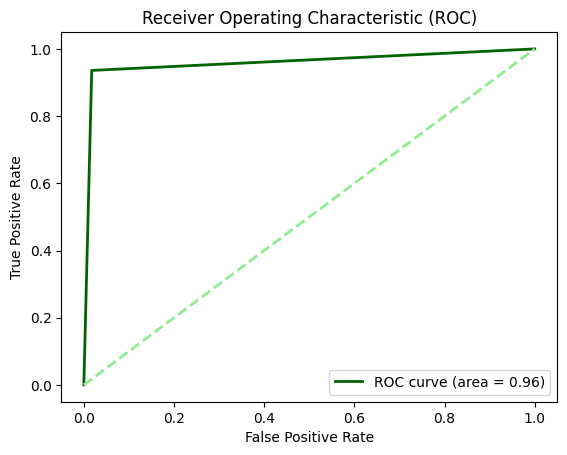

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color = 'darkgreen', lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'lightgreen', lw = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc = 'lower right')
plt.grid(False)
plt.show()

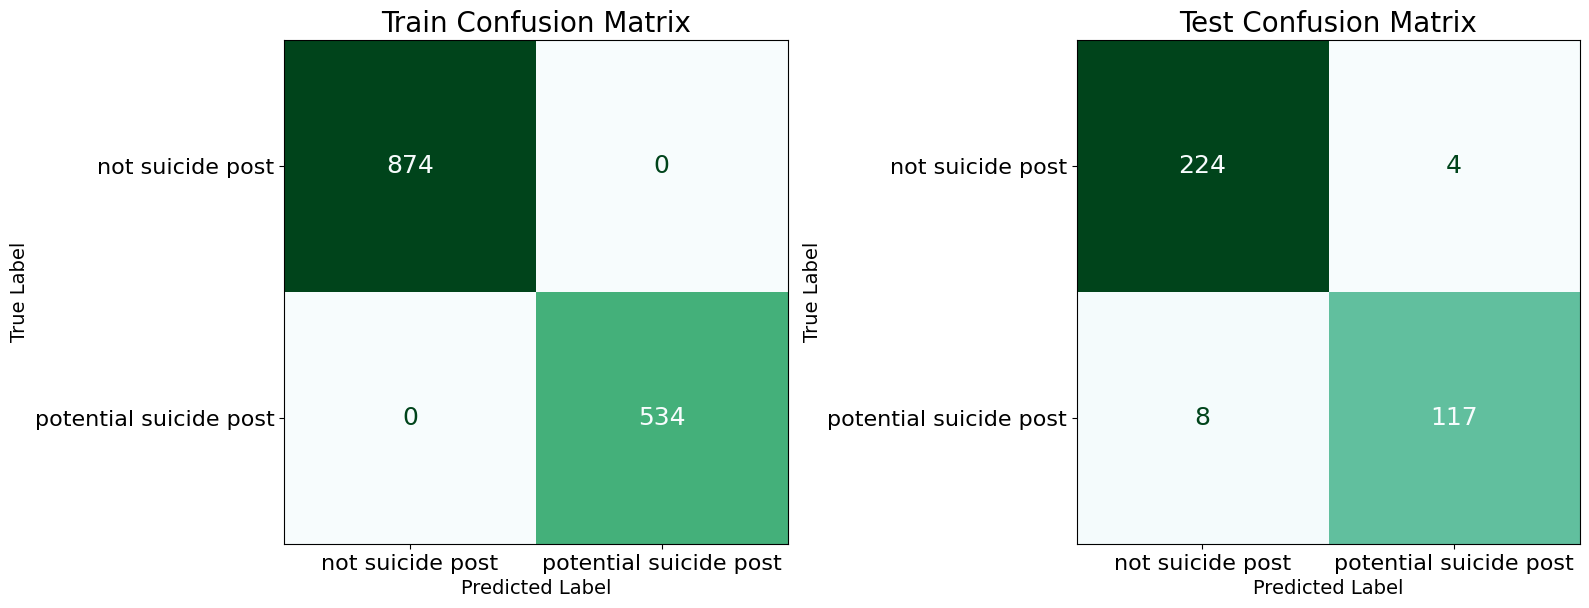

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

train_matrix = confusion_matrix(y_train, y_pred_train)
test_matrix = confusion_matrix(y_test, y_pred_test)

class_labels = ['not suicide post', 'potential suicide post']

disp_train = ConfusionMatrixDisplay(confusion_matrix=train_matrix, display_labels=class_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_matrix, display_labels=class_labels)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))  

# Train Confusion Matrix
disp_train.plot(ax=axs[0], cmap='BuGn', colorbar=False)
axs[0].set_title('Train Confusion Matrix', fontsize=20)  
axs[0].set_xlabel('Predicted Label', fontsize=14) 
axs[0].set_ylabel('True Label', fontsize=14) 
for label in axs[0].get_xticklabels() + axs[0].get_yticklabels():
    label.set_fontsize(16) 

# Test Confusion Matrix
disp_test.plot(ax=axs[1], cmap='BuGn', colorbar=False)
axs[1].set_title('Test Confusion Matrix', fontsize=20)  
axs[1].set_xlabel('Predicted Label', fontsize=14)  
axs[1].set_ylabel('True Label', fontsize=14)  
for label in axs[1].get_xticklabels() + axs[1].get_yticklabels():
    label.set_fontsize(16) 

for ax in axs:
    for text in ax.texts:
        text.set_fontsize(18) 

plt.tight_layout()
plt.show()